# Import Dependencies

In [53]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as st
from scipy import stats
from scipy.stats import linregress
from scipy.stats import pearsonr
from scipy.stats import ttest_rel
import seaborn as sns
import datetime


# 1. Read and load the Air Quality dataset

In [54]:
file_path = "data/aqs_nd.xlsx"
df = pd.read_excel(file_path, sheet_name='aqs_nd')
df

,CohortID,StudyID,Visit,Date,Staff,Population,Weight (lb),Height (inc),FVC_L,FVC%,...,FEV1/FVC,FEV1/FVC%,PEF_LPM,PEF%,DOB,"Gender (female = 0, male = 1)",Race Ethnicity,SBP,DBP,Ox
0,1,2004,Baseline,2019-09-19,21,Caucasian,147.0,66.0,4.31,111,...,0.80,99,473,110,1973-06-18,1,0,125,83,98
1,1,2011,Baseline,2019-09-17,21,Caucasian,206.0,70.0,5.38,113,...,0.71,90,661,120,1975-07-24,0,0,134,94,98
2,1,2014,Baseline,2019-09-19,22,Caucasian,165.0,63.0,3.47,125,...,0.78,99,416,115,1964-08-08,1,0,117,70,97
3,1,2015,Baseline,2019-09-26,22,Asian,172.0,65.0,4.18,120,...,0.72,92,539,111,1969-02-02,0,3,127,79,99
4,1,2024,Baseline,2019-09-18,21,Caucasian,147.0,69.0,5.00,105,...,0.79,103,589,105,1964-07-04,0,0,123,75,98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,3,2263,Year1,2023-10-13,24,Other,98.0,57.0,2.76,105,...,0.76,96,318,96,1968-01-14,1,4,106,62,98
59,3,2264,Baseline,2022-10-04,23,Caucasian,116.0,63.0,2.60,79,...,0.97,103,264,62,2008-11-27,0,0,92,52,99
60,3,2264,Year1,2023-06-30,24,Caucasian,132.0,66.0,3.52,93,...,0.86,91,344,73,2008-11-27,0,0,128,61,98
61,3,2265,Baseline,2022-10-04,23,Caucasian,156.0,68.0,3.63,88,...,0.69,73,269,54,2008-11-27,0,0,100,60,99


# 2. Perform Descriptive Statistics on The Dataset

In [55]:
descriptive_stats = df[['FVC_L', 'FEV1_L', 'FEV1/FVC', 'PEF_LPM', 'SBP', 'DBP', 'Ox']].describe()
descriptive_stats.describe()

,FVC_L,FEV1_L,FEV1/FVC,PEF_LPM,SBP,DBP,Ox
count,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000
mean,11.264828,10.444004,8.454508,390.084920,97.800993,63.356069,81.271767
std,20.966518,21.276334,22.041370,259.661162,42.329272,25.184459,34.518406
min,1.094179,0.868063,0.066223,63.000000,11.026988,8.904109,1.396360
25%,3.163750,2.321250,0.687500,136.045232,84.750000,60.250000,86.250000
50%,4.332222,3.376984,0.769921,450.750000,115.190476,68.750000,97.388889
75%,5.541250,4.226250,0.835000,528.089286,120.500000,74.083333,98.250000
max,63.000000,63.000000,63.000000,789.000000,142.000000,94.000000,100.000000


# 3. Define the Function for Paired T-Tests:

In [56]:
# Define a function to perform paired t-tests
def paired_t_tests(df, cohort_id):
    # Filter data for the specified cohort
    baseline = df[(df['CohortID'] == cohort_id) & (df['Visit'] == 'Baseline')]
    year1 = df[(df['CohortID'] == cohort_id) & (df['Visit'] == 'Year1')]
    year2 = df[(df['CohortID'] == cohort_id) & (df['Visit'] == 'Year2')]
    
    # Merge data
    merged_baseline_year1 = pd.merge(baseline, year1, on='StudyID', suffixes=('_baseline', '_year1'))
    merged_year1_year2 = pd.merge(year1, year2, on='StudyID', suffixes=('_year1', '_year2'))
    
    # Debugging: Check the merged data for missing values
    print(f"Cohort {cohort_id} - Merged Baseline vs Year1: {merged_baseline_year1.isnull().sum()}")
    print(f"Cohort {cohort_id} - Merged Year1 vs Year2: {merged_year1_year2.isnull().sum()}")

    # Drop rows with missing values
    matched_baseline_year1 = merged_baseline_year1.dropna(subset=['FVC_L_baseline', 'FVC_L_year1', 'FEV1_L_baseline', 'FEV1_L_year1', 'FEV1/FVC_baseline', 'FEV1/FVC_year1', 'PEF_LPM_baseline', 'PEF_LPM_year1'])
    matched_year1_year2 = merged_year1_year2.dropna(subset=['FVC_L_year1', 'FVC_L_year2', 'FEV1_L_year1', 'FEV1_L_year2', 'FEV1/FVC_year1', 'FEV1/FVC_year2', 'PEF_LPM_year1', 'PEF_LPM_year2'])
    
    # Debugging: Check the sizes of the matched data
    print(f"Cohort {cohort_id} - Matched Baseline vs Year1: {matched_baseline_year1.shape}")
    print(f"Cohort {cohort_id} - Matched Year1 vs Year2: {matched_year1_year2.shape}")
    
    # Perform paired t-tests
    results = {
        'Baseline_Year1': {
            'FVC_L': ttest_rel(matched_baseline_year1['FVC_L_baseline'], matched_baseline_year1['FVC_L_year1']),
            'FEV1_L': ttest_rel(matched_baseline_year1['FEV1_L_baseline'], matched_baseline_year1['FEV1_L_year1']),
            'FEV1/FVC': ttest_rel(matched_baseline_year1['FEV1/FVC_baseline'], matched_baseline_year1['FEV1/FVC_year1']),
            'PEF_LPM': ttest_rel(matched_baseline_year1['PEF_LPM_baseline'], matched_baseline_year1['PEF_LPM_year1'])
        },
        'Year1_Year2': {
            'FVC_L': ttest_rel(matched_year1_year2['FVC_L_year1'], matched_year1_year2['FVC_L_year2']),
            'FEV1_L': ttest_rel(matched_year1_year2['FEV1_L_year1'], matched_year1_year2['FEV1_L_year2']),
            'FEV1/FVC': ttest_rel(matched_year1_year2['FEV1/FVC_year1'], matched_year1_year2['FEV1/FVC_year2']),
            'PEF_LPM': ttest_rel(matched_year1_year2['PEF_LPM_year1'], matched_year1_year2['PEF_LPM_year2'])
        }
    }
    return results


# 4. Perform Paired T-Tests for Each Cohort:

In [57]:
# Perform paired t-tests for each cohort
results_cohort1 = paired_t_tests(df, 1)
results_cohort2 = paired_t_tests(df, 2)
results_cohort3 = paired_t_tests(df, 3)

Cohort 1 - Merged Baseline vs Year1: CohortID_baseline                         0
StudyID                                   0
Visit_baseline                            0
Date_baseline                             0
Staff_baseline                            0
Population_baseline                       0
Weight (lb)_baseline                      0
Height (inc)_baseline                     0
FVC_L_baseline                            0
FVC%_baseline                             0
FEV1_L_baseline                           0
FEV1%_baseline                            0
FEV1/FVC_baseline                         0
FEV1/FVC%_baseline                        0
PEF_LPM_baseline                          0
PEF%_baseline                             0
DOB_baseline                              0
Gender (female = 0, male = 1)_baseline    0
Race Ethnicity_baseline                   0
SBP_baseline                              0
DBP_baseline                              0
Ox_baseline                            

# 5. Prepare and Save Results:

In [58]:
# Prepare results for each cohort
def prepare_results(cohort_id, results):
    results_df = pd.DataFrame({
        'Comparison': ['Baseline vs Year1'] * 4 + ['Year1 vs Year2'] * 4,
        'Metric': ['FVC_L', 'FEV1_L', 'FEV1/FVC', 'PEF_LPM'] * 2,
        'T-Statistic': [results['Baseline_Year1']['FVC_L'][0], results['Baseline_Year1']['FEV1_L'][0], results['Baseline_Year1']['FEV1/FVC'][0], results['Baseline_Year1']['PEF_LPM'][0],
                        results['Year1_Year2']['FVC_L'][0], results['Year1_Year2']['FEV1_L'][0], results['Year1_Year2']['FEV1/FVC'][0], results['Year1_Year2']['PEF_LPM'][0]],
        'P-Value': [results['Baseline_Year1']['FVC_L'][1], results['Baseline_Year1']['FEV1_L'][1], results['Baseline_Year1']['FEV1/FVC'][1], results['Baseline_Year1']['PEF_LPM'][1],
                    results['Year1_Year2']['FVC_L'][1], results['Year1_Year2']['FEV1_L'][1], results['Year1_Year2']['FEV1/FVC'][1], results['Year1_Year2']['PEF_LPM'][1]]
    })
    return results_df

results_df_cohort1 = prepare_results(1, results_cohort1)
results_df_cohort2 = prepare_results(2, results_cohort2)
results_df_cohort3 = prepare_results(3, results_cohort3)

# Save results to CSV files
output_path = 'C:/Users/NgalaKA/air quality study/output/'
results_df_cohort1.to_csv(output_path + 'paired_t_test_results_cohort1.csv', index=False)
results_df_cohort2.to_csv(output_path + 'paired_t_test_results_cohort2.csv', index=False)
results_df_cohort3.to_csv(output_path + 'paired_t_test_results_cohort3.csv', index=False)


In [90]:
print(results_df_cohort1) 
print(results_df_cohort2)
print(results_df_cohort3)

          Comparison    Metric  T-Statistic   P-Value
0  Baseline vs Year1     FVC_L     5.566856  0.000238
1  Baseline vs Year1    FEV1_L     1.196582  0.259068
2  Baseline vs Year1  FEV1/FVC    -1.846905  0.094523
3  Baseline vs Year1   PEF_LPM     0.115468  0.910360
4     Year1 vs Year2     FVC_L     2.342606  0.100982
5     Year1 vs Year2    FEV1_L     0.731789  0.517280
6     Year1 vs Year2  FEV1/FVC     0.000000  1.000000
7     Year1 vs Year2   PEF_LPM     0.982108  0.398467
          Comparison    Metric  T-Statistic   P-Value
0  Baseline vs Year1     FVC_L     2.681170  0.027875
1  Baseline vs Year1    FEV1_L     0.526290  0.612961
2  Baseline vs Year1  FEV1/FVC    -1.455214  0.183698
3  Baseline vs Year1   PEF_LPM     0.734042  0.483879
4     Year1 vs Year2     FVC_L     0.197181  0.861908
5     Year1 vs Year2    FEV1_L    -0.146183  0.897181
6     Year1 vs Year2  FEV1/FVC    -0.285714  0.801970
7     Year1 vs Year2   PEF_LPM   -59.000000  0.000287
          Comparison    Metr

# 6. Select Relevant Columns for Correlation Analysis:

In [62]:
# Select relevant columns for correlation analysis
columns_of_interest = [
    'FVC_L', 'FEV1_L', 'FEV1/FVC', 'PEF_LPM', 
    'Height (inc)', 'Weight (lb)', 'SBP', 'DBP', 'Ox', 
    'Gender (female = 0, male = 1)', 'Age'
]

# Calculate Age from DOB
df['DOB'] = pd.to_datetime(df['DOB'])
df['Age'] = (pd.to_datetime('today') - df['DOB']).dt.days / 365.25

# Filter the dataframe with the selected columns
df_filtered = df[columns_of_interest]

# Drop rows with missing values
df_filtered = df_filtered.dropna()


# a. Compute the Correlation Matrix:

In [73]:
# Compute the correlation matrix
correlation_matrix = df_filtered.corr()

# Display the correlation matrix
print("Correlation matrix:")
correlation_matrix

# Save the correlation matrix to a CSV file
output_path = 'C:/Users/NgalaKA/air quality study/output/correlation_matrix.csv'
correlation_matrix.to_csv(output_path)

Correlation matrix:


# b. Comparisons between Cohorts at Specific Time Points (ANOVA)


In [66]:
# Iterate through visits and variables for one-way ANOVA
for visit in df['Visit'].unique():
    for variable in ['FVC_L', 'FEV1_L', 'FEV1/FVC', 'PEF_LPM']:
        groups = [df[(df['CohortID'] == i) & (df['Visit'] == visit)][variable] for i in range(1, 4)]
        if all(len(g) > 0 for g in groups):
            f_statistic, p_value = stats.f_oneway(*groups)
            print(f"{variable} at {visit} across cohorts: F-statistic = {f_statistic}, p-value = {p_value}")

# --- Relationship between Variables (Correlation and Regression) ---

# Calculate correlations between variables
correlation_matrix = df[['Weight (lb)', 'FVC_L', 'FEV1_L', 'FEV1/FVC', 'PEF_LPM']].corr()
print("\nCorrelation Matrix:\n", correlation_matrix)

# Perform linear regression (example: FVC_L as dependent variable, Weight as independent)
from scipy.stats import linregress
result = linregress(df['Weight (lb)'], df['FVC_L'])
print("\nLinear Regression (FVC_L vs. Weight):")
print("Slope:", result.slope)
print("Intercept:", result.intercept)
print("R-squared:", result.rvalue**2)

output_path = output_path = 'C:/Users/NgalaKA/air quality study/output/anova_results.csv.csv' # Specify the desired output path

# Store ANOVA results
anova_results = []
for visit in df['Visit'].unique():
    for variable in ['FVC_L', 'FEV1_L', 'FEV1/FVC', 'PEF_LPM']:
        groups = [df[(df['CohortID'] == i) & (df['Visit'] == visit)][variable] for i in range(1, 4)]
        if all(len(g) > 0 for g in groups):
            f_statistic, p_value = stats.f_oneway(*groups)
            anova_results.append({
                'Visit': visit,
                'Variable': variable,
                'F-statistic': f_statistic,
                'p-value': p_value
            })

# Create a DataFrame from the ANOVA results
anova_df = pd.DataFrame(anova_results)

# Concatenate original data and ANOVA results (adjust as needed)
combined_df = pd.concat([df, anova_df], ignore_index=True, sort=False)

# Export the combined DataFrame to CSV
combined_df.to_csv(output_path, index=False)

print(f"Analysis results saved to {output_path}")

FVC_L at Baseline across cohorts: F-statistic = 0.6272349541856628, p-value = 0.5422623257895185
FEV1_L at Baseline across cohorts: F-statistic = 0.33335969761630424, p-value = 0.719648749851206
FEV1/FVC at Baseline across cohorts: F-statistic = 0.3142329129945729, p-value = 0.733191621869811
PEF_LPM at Baseline across cohorts: F-statistic = 2.450960952488999, p-value = 0.1066623927887485
FVC_L at Year1 across cohorts: F-statistic = 0.30837217137473083, p-value = 0.7376320679874477
FEV1_L at Year1 across cohorts: F-statistic = 0.19217326177463215, p-value = 0.8264752961247309
FEV1/FVC at Year1 across cohorts: F-statistic = 0.06272334022945303, p-value = 0.9393633628483258
PEF_LPM at Year1 across cohorts: F-statistic = 0.4376464331005238, p-value = 0.650818631386761
FVC_L at Year2 across cohorts: F-statistic = 0.7387010704200283, p-value = 0.5166560712648783
FEV1_L at Year2 across cohorts: F-statistic = 0.5184779873832532, p-value = 0.6198680461036217
FEV1/FVC at Year2 across cohorts: F

# c. Write the null hypothesis and the alternate hypothesis.

In [72]:
# Add a column to the dataframe and write a code based on p-value to determine whether to reject or fail to reject the null hypothesis.
# Null Hypothesis (H0): There is no significant difference in the means of the variable across the different cohorts at each visit.
# Alternate Hypothesis (H1): There is a significant difference in the means of the variable across the different cohorts at each visit.
# Add a column to anova_df for hypothesis test result

anova_df['Hypothesis Result'] = ''

# Set significance level (alpha)
alpha = 0.05

# Iterate through anova_df and determine hypothesis result
for index, row in anova_df.iterrows():
    p_value = row['p-value']
    # Determine hypothesis result
    hypothesis_result = 'Reject Null Hypothesis' if p_value < alpha else 'Fail to Reject Null Hypothesis'
    # Update anova_df
    anova_df.at[index, 'Hypothesis Result'] = hypothesis_result

# Display the updated anova_df
print(anova_df.head())

# Save the updated anova_df to a CSV file
output_path = 'C:/Users/NgalaKA/air quality study/output/anova_results_with_hypothesis.csv'
anova_df.to_csv(output_path, index=False)
print(f"Updated ANOVA results saved to {output_path}")


      Visit  Variable  F-statistic   p-value               Hypothesis Result
0  Baseline     FVC_L     0.627235  0.542262  Fail to Reject Null Hypothesis
1  Baseline    FEV1_L     0.333360  0.719649  Fail to Reject Null Hypothesis
2  Baseline  FEV1/FVC     0.314233  0.733192  Fail to Reject Null Hypothesis
3  Baseline   PEF_LPM     2.450961  0.106662  Fail to Reject Null Hypothesis
4     Year1     FVC_L     0.308372  0.737632  Fail to Reject Null Hypothesis
Updated ANOVA results saved to C:/Users/NgalaKA/air quality study/output/anova_results_with_hypothesis.csv


# Data Visualization: Time Series Plots for Each Cohort and Variable

# Linear Regression Analyses

In [86]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate Age from DOB if needed for other analyses
df['DOB'] = pd.to_datetime(df['DOB'])
df['Age'] = (pd.to_datetime('today') - df['DOB']).dt.days / 365.25

# Plot the linear regression between 'FVC_L' and 'Weight (lb)'
plt.figure(figsize=(10, 6))
sns.regplot(x='Weight (lb)', y='FVC_L', data=df, line_kws={"color":"red"})
plt.title('Linear Regression: FVC_L vs. Weight (lb)')
plt.xlabel('Weight (lb)')
plt.ylabel('FVC_L')
plt.grid(True)

# Save the plot
output_path = os.path.join(output_directory, 'linear_regression_FVC_L_vs_Weight.png')
plt.savefig(output_path)
plt.close()

print(f"Linear regression plot saved to {output_path}")

Linear regression plot saved to C:/Users/NgalaKA/air quality study/output/linear_regression_FVC_L_vs_Weight.png


# Time Series Analyses

In [81]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert 'Visit' to categorical type to ensure correct ordering
visit_order = ['Baseline', 'Year1', 'Year2', 'Year3']
df['Visit'] = pd.Categorical(df['Visit'], categories=visit_order, ordered=True)

# Define a color palette with brighter colors
bright_palette = sns.color_palette("Set2", n_colors=len(df['CohortID'].unique()))

# Variables to plot
variables = ['FVC_L', 'FEV1_L', 'FEV1/FVC', 'PEF_LPM']

# Ensure the output directory exists
output_directory = 'C:/Users/NgalaKA/air quality study/output/'
os.makedirs(output_directory, exist_ok=True)

# Create a time series plot for each variable by cohort with brighter colors
for variable in variables:
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df, x='Visit', y=variable, hue='CohortID', palette=bright_palette, marker='o')
    plt.title(f'Time Series Plot of {variable} by Cohort')
    plt.xlabel('Visit')
    plt.ylabel(variable)
    plt.grid(True)
    plt.legend(title='CohortID')
    
    # Replace '/' with '_' in filenames
    variable_sanitized = variable.replace('/', '_')
    output_path = os.path.join(output_directory, f'time_series_{variable_sanitized}_bright.png')
    
    plt.savefig(output_path)
    plt.close()
    print(f"Plot for {variable} saved to {output_path}")

Plot for FVC_L saved to C:/Users/NgalaKA/air quality study/output/time_series_FVC_L_bright.png
Plot for FEV1_L saved to C:/Users/NgalaKA/air quality study/output/time_series_FEV1_L_bright.png
Plot for FEV1/FVC saved to C:/Users/NgalaKA/air quality study/output/time_series_FEV1_FVC_bright.png
Plot for PEF_LPM saved to C:/Users/NgalaKA/air quality study/output/time_series_PEF_LPM_bright.png


In [84]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convert 'Visit' to categorical type to ensure correct ordering
visit_order = ['Baseline', 'Year1', 'Year2', 'Year3']
df['Visit'] = pd.Categorical(df['Visit'], categories=visit_order, ordered=True)

# Define the output directory
output_directory = 'C:/Users/NgalaKA/air quality study/output/'
os.makedirs(output_directory, exist_ok=True)

# --- Time Series Plots for Each Cohort and Variable ---
for cohort in df['CohortID'].unique():
    plt.figure()
    for variable in ['FVC_L', 'FEV1_L', 'FEV1/FVC', 'PEF_LPM']:
        cohort_data = df[df['CohortID'] == cohort]
        sns.lineplot(x='Visit', y=variable, data=cohort_data, label=variable)
    plt.title(f'Cohort {cohort} - Changes Over Time')
    plt.xlabel('Visit')
    plt.ylabel('Value')
    plt.legend()
    output_path = os.path.join(output_directory, f'time_series_cohort_{cohort}.png')
    plt.savefig(output_path)
    plt.close()
    print(f"Time series plot for Cohort {cohort} saved to {output_path}")

# --- Box Plots for Comparisons between Cohorts at Each Visit ---
for visit in df['Visit'].unique():
    plt.figure()
    for variable in ['FVC_L', 'FEV1_L', 'FEV1/FVC', 'PEF_LPM']:
        variable_sanitized = variable.replace('/', '_')
        sns.boxplot(x='CohortID', y=variable, data=df[df['Visit'] == visit])
        plt.title(f'{variable} at {visit} - Comparison between Cohorts')
        plt.xlabel('Cohort ID')
        plt.ylabel(variable)
        output_path = os.path.join(output_directory, f'boxplot_{variable_sanitized}_{visit}.png')
        plt.savefig(output_path)
        plt.close()
        print(f"Box plot for {variable} at {visit} saved to {output_path}")

# --- Scatter Plots with Regression Lines for Correlation Analysis ---
sns.pairplot(df[['Weight (lb)', 'FVC_L', 'FEV1_L', 'FEV1/FVC', 'PEF_LPM']], kind='reg')
output_path = os.path.join(output_directory, 'correlation_scatter_plots.png')
plt.savefig(output_path)
plt.close()
print(f"Scatter plots for correlation analysis saved to {output_path}")


Time series plot for Cohort 1 saved to C:/Users/NgalaKA/air quality study/output/time_series_cohort_1.png
Time series plot for Cohort 2 saved to C:/Users/NgalaKA/air quality study/output/time_series_cohort_2.png
Time series plot for Cohort 3 saved to C:/Users/NgalaKA/air quality study/output/time_series_cohort_3.png
Box plot for FVC_L at Baseline saved to C:/Users/NgalaKA/air quality study/output/boxplot_FVC_L_Baseline.png
Box plot for FEV1_L at Baseline saved to C:/Users/NgalaKA/air quality study/output/boxplot_FEV1_L_Baseline.png
Box plot for FEV1/FVC at Baseline saved to C:/Users/NgalaKA/air quality study/output/boxplot_FEV1_FVC_Baseline.png
Box plot for PEF_LPM at Baseline saved to C:/Users/NgalaKA/air quality study/output/boxplot_PEF_LPM_Baseline.png
Box plot for FVC_L at Year1 saved to C:/Users/NgalaKA/air quality study/output/boxplot_FVC_L_Year1.png
Box plot for FEV1_L at Year1 saved to C:/Users/NgalaKA/air quality study/output/boxplot_FEV1_L_Year1.png
Box plot for FEV1/FVC at Y

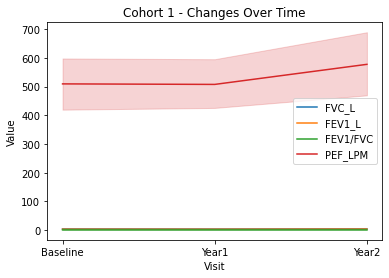

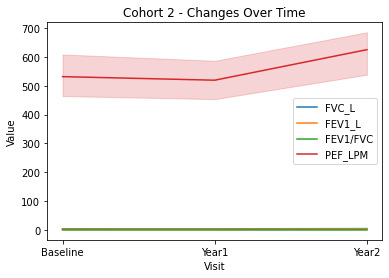

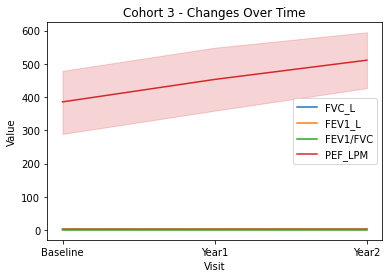

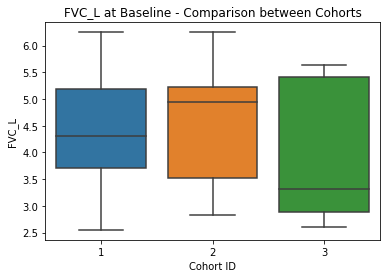

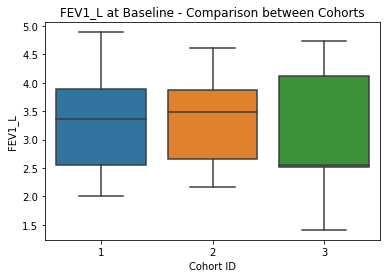

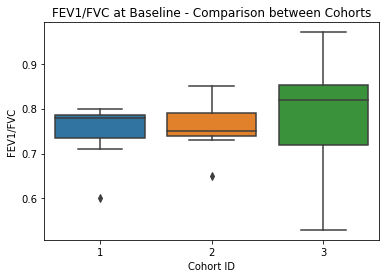

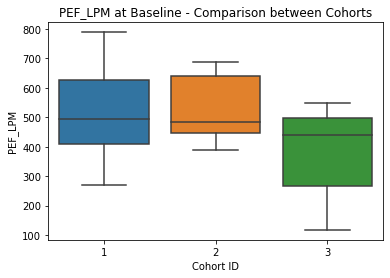

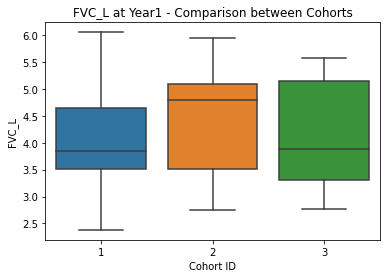

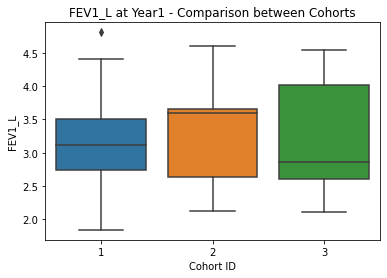

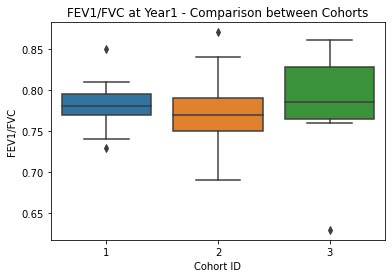

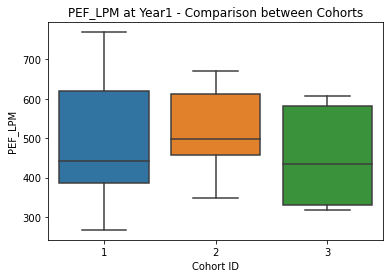

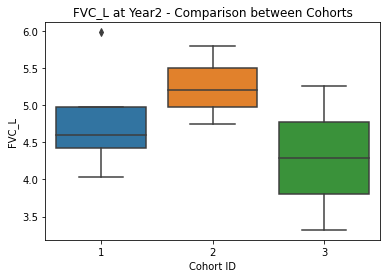

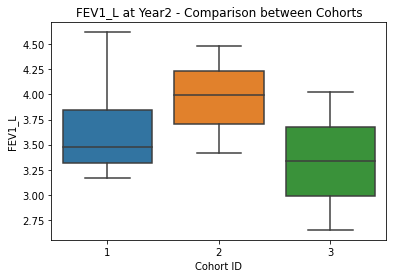

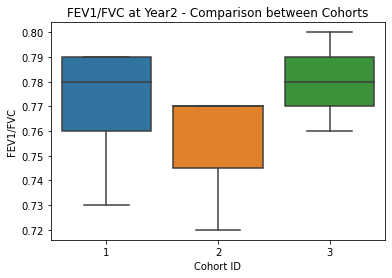

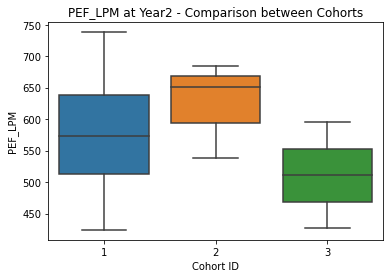

<Figure size 432x288 with 0 Axes>

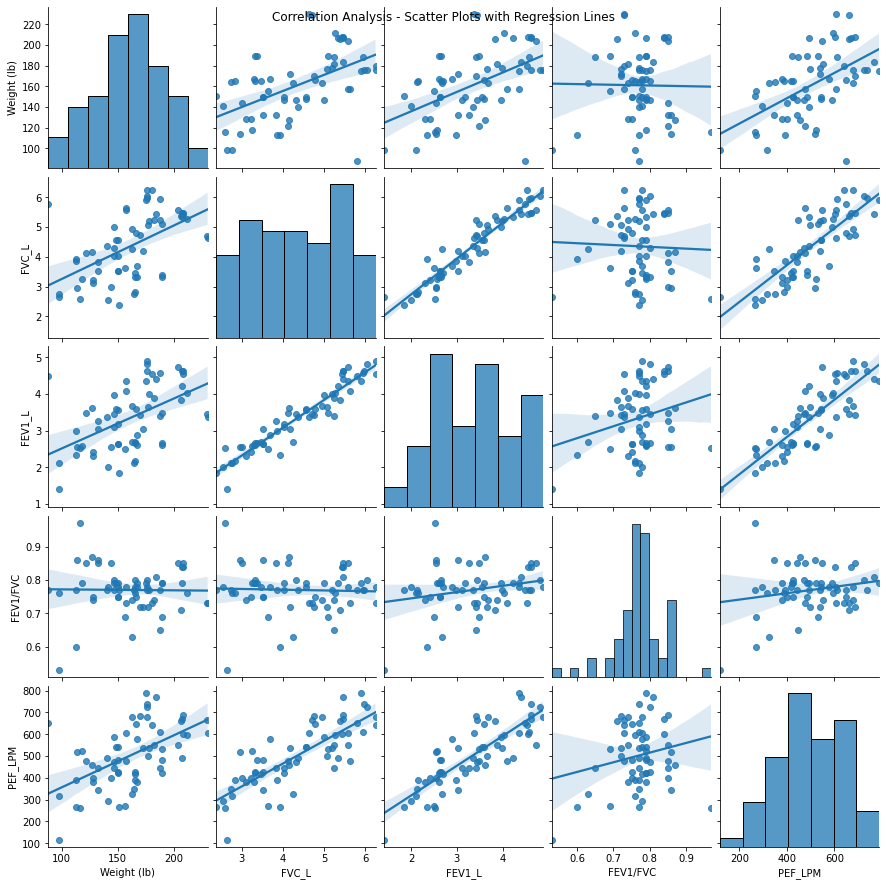

In [39]:
# prompt: plot all charts

import matplotlib.pyplot as plt
import seaborn as sns

# --- Time Series Plots for Each Cohort and Variable ---

for cohort in df['CohortID'].unique():
    plt.figure()
    for variable in ['FVC_L', 'FEV1_L', 'FEV1/FVC', 'PEF_LPM']:
        cohort_data = df[df['CohortID'] == cohort]
        sns.lineplot(x='Visit', y=variable, data=cohort_data, label=variable)
    plt.title(f'Cohort {cohort} - Changes Over Time')
    plt.xlabel('Visit')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

# --- Box Plots for Comparisons between Cohorts at Each Visit ---

for visit in df['Visit'].unique():
    plt.figure()
    for variable in ['FVC_L', 'FEV1_L', 'FEV1/FVC', 'PEF_LPM']:
        sns.boxplot(x='CohortID', y=variable, data=df[df['Visit'] == visit])
        plt.title(f'{variable} at {visit} - Comparison between Cohorts')
        plt.xlabel('Cohort ID')
        plt.ylabel(variable)
        plt.show()

# --- Scatter Plots with Regression Lines for Correlation Analysis ---

plt.figure()
sns.pairplot(df[['Weight (lb)', 'FVC_L', 'FEV1_L', 'FEV1/FVC', 'PEF_LPM']], kind='reg')
plt.suptitle('Correlation Analysis - Scatter Plots with Regression Lines')
plt.show()
